In [1]:
import numpy as np
import mass_balance as mb
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Math
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':'16'})
rc('text', usetex=False)

This notebook is based on OS16_final. 

Questions: 
- What happens when we use more recent exchange parameters? 
- What happens when we do dissolution? 

In [2]:
Tcmb = np.linspace(6000,3000,1001)
dT   = Tcmb[1]-Tcmb[0]

# Data taken from Extended Data Table 1 of O16 and my fit to B18 exchange data
a_Mg_D19_E, b_Mg_D19_E, c_Mg_D19_E = -3.00, -2314, 26.0   #                                (Exchange)
a_Mg_D19_E, b_Mg_D19_E, c_Mg_D19_E = -2.30, -2900, 16.0   #                                (Exchange) Fig 3
a_Mg_B18_E, b_Mg_B18_E, c_Mg_B18_E = -1.45, -3600, 0.0    #                                (Exchange)
a_Mg_O16_E, b_Mg_O16_E, c_Mg_O16_E = 0.1 ,-10851,0.0  # OS16                               (Exchange)
a_Mg_B18_Ds, b_Mg_B18_Ds, c_Mg_B18_Ds = -1.04, -6151, 0.0 #                                (Dissociation)
Kd_Mg_O16_E  = 10**mb.logKd(a_Mg_O16_E , b_Mg_O16_E , c_Mg_O16_E , Tcmb)
Kd_Mg_B18_E  = 10**mb.logKd(a_Mg_B18_E , b_Mg_B18_E , c_Mg_B18_E , Tcmb)
Kd_Mg_D19_E  = 10**mb.logKd(a_Mg_D19_E , b_Mg_D19_E , c_Mg_D19_E , Tcmb)
Kd_Mg_B18_Ds = 10**mb.logKd(a_Mg_B18_Ds, b_Mg_B18_Ds, c_Mg_B18_Ds, Tcmb)

a_Si_O16, b_Si_O16, c_Si_O16 = 1.3 ,-13500,0.0  # Originally from Fischer et al 2015 (Exchange)
a_O_O16 , b_O_O16 , c_O_O16  = 0.6 ,-3800 ,22.0 # Originally from Fischer et al 2015 (Dissolution)
a_O_M20 , b_O_M20 , c_O_M20  =-0.3 , 0.0  ,-36.8
Kd_O         = 10**mb.logKd(a_O_O16 , b_O_O16 , c_O_O16 , Tcmb) 
Kd_O_M20     = 10**mb.logKd(a_O_M20 , b_O_M20 , c_O_M20 , Tcmb) 
Kd_Si        = 10**mb.logKd(a_Si_O16, b_Si_O16, c_Si_O16, Tcmb) 
Kd_Si_Ds     = 2*Kd_Si * (Kd_O_M20)**2

# O16 0.25 sigms soln
fac = 0.25
a_O_O16_25s , b_O_O16_25s , c_O_O16_25s  = (a_O_O16-fac*0.4), (b_O_O16+fac*900) , (c_O_O16-fac*14) 

Kd_Mg_25s = 10**mb.logKd(a_Mg_O16_E , b_Mg_O16_E , c_Mg_O16_E , Tcmb)   
Kd_O_25s  = 10**mb.logKd(a_O_O16_25s, b_O_O16_25s, c_O_O16_25s, Tcmb) 
Kd_Si_25s = 10**mb.logKd(a_Si_O16   , b_Si_O16   , c_Si_O16   , Tcmb) 

verbose = 2
var     = 1

print(-3.00 -10*np.log10(1-0.1),-3.00 -10*np.log10(1-0.15), -3.00 -10*np.log10(1-0.07))

-2.542425094393249 -2.294189257142927 -2.6848294855393506


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


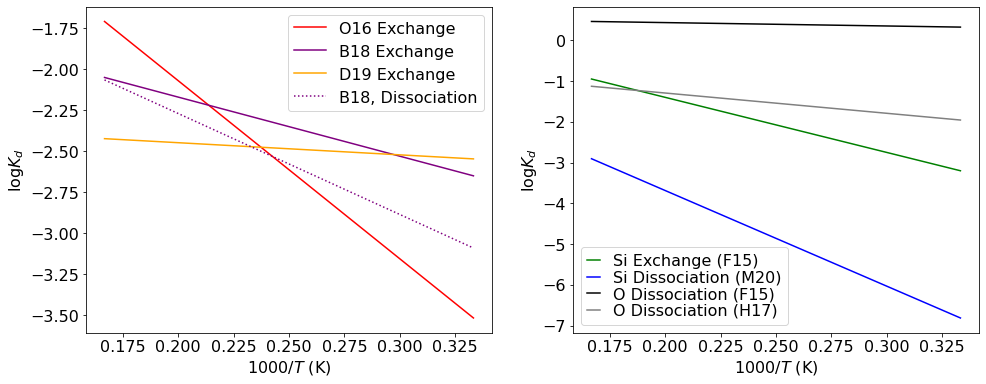

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.set_xlabel("$1000/T$ (K)")
ax1.set_ylabel("$\log K_d$")
#ax1.set_yscale('log')
#ax1.set_ylim([1e-4, 1e-1])
ax1.plot(1000/Tcmb, np.log10(Kd_Mg_O16_E), label="O16 Exchange", color="red")
ax1.plot(1000/Tcmb, np.log10(Kd_Mg_B18_E), label="B18 Exchange", color="purple")
ax1.plot(1000/Tcmb, np.log10(Kd_Mg_D19_E), label="D19 Exchange", color="orange")
ax1.plot(1000/Tcmb, np.log10(Kd_Mg_B18_Ds), label="B18, Dissociation", color="purple", ls=':')
ax1.legend()

ax2.set_xlabel("$1000/T$ (K)")
ax2.set_ylabel("$\log K_d$")
#ax2.set_yscale('log')
ax2.plot(1000/Tcmb, np.log10(Kd_Si)    , label="Si Exchange (F15)", color="green")
ax2.plot(1000/Tcmb, np.log10(Kd_Si_Ds) , label="Si Dissociation (M20)", color="blue")
ax2.plot(1000/Tcmb, np.log10(Kd_O)     , label="O Dissociation (F15)" , color="black")
ax2.plot(1000/Tcmb, np.log10(Kd_O_M20) , label="O Dissociation (H17)" , color="grey")
ax2.legend( labelspacing=0.1,handlelength=0.8 )
fig.savefig("var_Kd.pdf", format='pdf',bbox_inches="tight")

### Compare O16, B18 and D19 solutions

In [4]:
iMFe, iMO, iMSi, iMMg = 575, 135, 40, 30 # Default composition of 780 atoms in Core and BMO
iMFeO, iMMgO, iMSiO2  = 220, 500, 60
iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
O16_E     = mb.run_massbalance(iM, [Kd_Mg_O16_E , Kd_O    , Kd_Si]    , Tcmb, 1, verbose)
B18_E     = mb.run_massbalance(iM, [Kd_Mg_B18_E , Kd_O    , Kd_Si]    , Tcmb, 1, verbose)
D19_E     = mb.run_massbalance(iM, [Kd_Mg_D19_E , Kd_O    , Kd_Si]    , Tcmb, 1, verbose)
O16_E_25s = mb.run_massbalance(iM, [Kd_Mg_25s   , Kd_O_25s, Kd_Si_25s], Tcmb, 1, verbose)
B18_D     = mb.run_massbalance(iM, [Kd_Mg_B18_Ds, Kd_O    , Kd_Si]    , Tcmb, 3, verbose)

if verbose == 1:
    mb.print_init_conc(O16_E[0],O16_E[2])
    mb.print_any_conc(O16_E[1],O16_E[3],-1)
    mb.plot_all(Tcmb, O16_E_25s[5], O16_E_25s[1], O16_E_25s[3], O16_E_25s[4])
    mb.plot_paper(Tcmb, O16_E[5], O16_E[1], O16_E[3], O16_E[4])
    mb.plot_paper(Tcmb, B18_E[5], B18_E[1], B18_E[3], B18_E[4])
    mb.plot_paper(Tcmb, D19_E[5], D19_E[1], D19_E[3], D19_E[4])

MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Dissociation


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


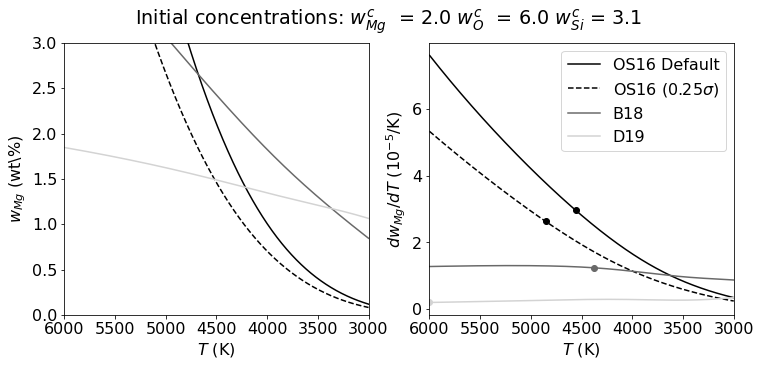

In [5]:
fig, ((ax3, ax5)) = plt.subplots(1, 2, figsize=(12,5))

# wt% Mg (element 3)
ax3.set_xlim([np.max(Tcmb),np.min(Tcmb)])
ax3.set_ylim([0,3])       # To compare to the Du plot. 
ax3.set_xlabel("$T$ (K)")
ax3.set_ylabel("$w_{Mg}$ (wt\%)")
ax3.plot(Tcmb, O16_E[3][3]*100    , color='black'    , label="O16 Default")
ax3.plot(Tcmb, O16_E_25s[3][3]*100, color='black'    , label="O16 ($0.25\sigma$)", ls='--')
ax3.plot(Tcmb, B18_E[3][3]*100    , color='dimgrey'  , label="B18")
ax3.plot(Tcmb, D19_E[3][3]*100    , color='lightgrey', label="D19")
#ax3.legend()

# change in MgO conc (element 5)
fig.suptitle("Initial concentrations: $w_{Mg}^c$  = "+str(np.round(O16_E[2][3]*100,1)) + 
                 " $w_{O}^c$  = "+str(np.round(O16_E[2][1]*100,1)) + 
                 " $w_{Si}^c$ = "+str(np.round(O16_E[2][2]*100,1)))
ax5.set_xlim([np.max(Tcmb),np.min(Tcmb)])
ax5.set_xlabel("$T$ (K)")
ax5.set_ylabel("$d w_{Mg}/dT$ ($10^{-5}$/K)")
ax5.plot(Tcmb, O16_E[6][2]    , color='black'    , label="OS16 Default"       , linestyle='-')
ax5.plot(Tcmb, O16_E_25s[6][2], color='black'    , label="OS16 ($0.25\sigma$)", linestyle='--')
ax5.plot(Tcmb, B18_E[6][2]    , color='dimgrey'  , label="B18"                , linestyle='-')
ax5.plot(Tcmb, D19_E[6][2]    , color='lightgrey', label="D19"                , linestyle='-')
ax5.plot(Tcmb[O16_E[4][2]]    , O16_E[6][2][O16_E[4][2]]        , color='black'    , marker='o')
ax5.plot(Tcmb[O16_E_25s[4][2]], O16_E_25s[6][2][O16_E_25s[4][2]], color='black'    , marker='o')
ax5.plot(Tcmb[B18_E[4][2]]    , B18_E[6][2][B18_E[4][2]]        , color='dimgrey'  , marker='o')
ax5.plot(Tcmb[D19_E[4][2]]    , D19_E[6][2][D19_E[4][2]]        , color='lightgrey', marker='o')
ax5.legend()
fig.savefig("var_compMg.pdf", format='pdf',bbox_inches="tight")

### Solution at the conditions of B18 Fig 3a: 
- 3 wt% O, 3 wt % Si and 0 Mg in the core
- 50 mol% MgO

MgO Exchange
Initial core mole fractions of Fe  =   0.85 O   =   0.10 Si   =   0.06 Mg  =   0.00 All =   1.00
Initial mant mole fractions of FeO =   0.28 MgO =   0.64 SiO2 =   0.08 all =   1.00
Initial core mass fractions of O   =   3.04 Mg  =   0.00 Si  =   3.20
Initial mant mass fractions of FeO =  40.16 MgO =  50.71 SiO2 =   9.13
Core mole fractions of Fe  =   0.78 O   =   0.19 Si   =   0.01 Mg  =   0.02 All =   1.00
Mant mole fractions of FeO =   0.07 MgO =   0.78 SiO2 =   0.15 all =   1.00
Core mass fractions of O   =   6.48 Mg  =   0.97 Si  =   0.68
Mant mass fractions of FeO =  11.27 MgO =  68.78 SiO2 =  19.95


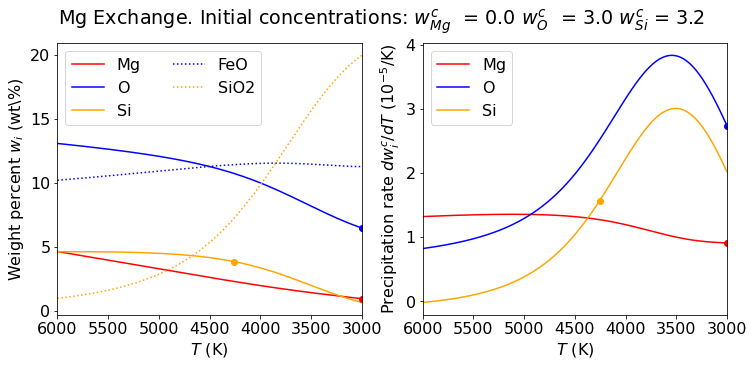

In [6]:
iMFe, iMO, iMSi, iMMg = 660, 75, 45, 0 # Default composition
iMFeO, iMMgO, iMSiO2  = 220, 500, 60
iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
B18_E_Fig3E = mb.run_massbalance(iM, [Kd_Mg_B18_E, Kd_O, Kd_Si], Tcmb, 1, verbose)

mb.print_init_conc(B18_E_Fig3E[0],B18_E_Fig3E[2])
mb.print_any_conc(B18_E_Fig3E[1],B18_E_Fig3E[3],-1)
fig, ax1, ax2 = mb.plot_paper(Tcmb, B18_E_Fig3E[5], B18_E_Fig3E[1], B18_E_Fig3E[3], B18_E_Fig3E[4])

fig.suptitle("Mg Exchange. Initial concentrations: $w_{Mg}^c$  = "+str(np.round(B18_E_Fig3E[2][3]*100,1)) + 
                 " $w_{O}^c$  = "+str(np.round(B18_E_Fig3E[2][1]*100,1)) + 
                 " $w_{Si}^c$ = "+str(np.round(B18_E_Fig3E[2][2]*100,1)))
fig.savefig("var_b18_E.pdf", format='pdf',bbox_inches="tight")

MgO Dissociation
Initial core mole fractions of Fe  =   0.85 O   =   0.10 Si   =   0.06 Mg  =   0.00 All =   1.00
Initial mant mole fractions of FeO =   0.28 MgO =   0.64 SiO2 =   0.08 all =   1.00
Initial core mass fractions of O   =   3.04 Mg  =   0.00 Si  =   3.20
Initial mant mass fractions of FeO =  40.16 MgO =  50.71 SiO2 =   9.13
Core mole fractions of Fe  =   0.80 O   =   0.18 Si   =   0.01 Mg  =   0.00 All =   1.00
Mant mole fractions of FeO =   0.07 MgO =   0.78 SiO2 =   0.15 all =   1.00
Core mass fractions of O   =   6.05 Mg  =   0.17 Si  =   0.71
Mant mass fractions of FeO =  11.08 MgO =  69.54 SiO2 =  19.38


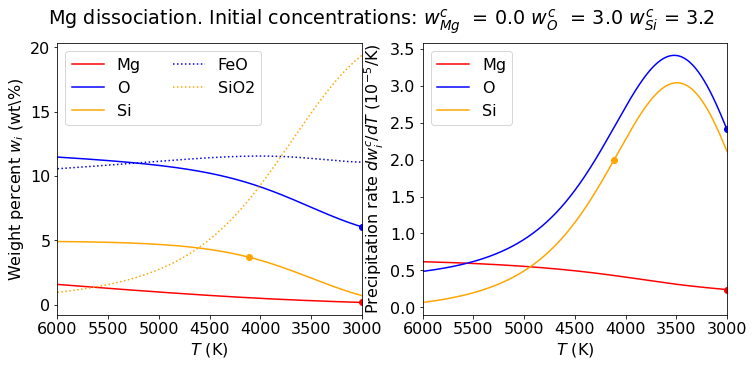

In [7]:
iMFe, iMO, iMSi, iMMg = 660, 75, 45, 0 # Default composition
iMFeO, iMMgO, iMSiO2  = 220, 500, 60
iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
B18_E_Fig3D = mb.run_massbalance(iM, [Kd_Mg_B18_Ds, Kd_O, Kd_Si], Tcmb, 3, verbose)

mb.print_init_conc(B18_E_Fig3D[0],B18_E_Fig3D[2])
mb.print_any_conc(B18_E_Fig3D[1],B18_E_Fig3D[3],-1)
fig, ax1, ax2 = mb.plot_paper(Tcmb, B18_E_Fig3D[5], B18_E_Fig3D[1], B18_E_Fig3D[3], B18_E_Fig3D[4])

fig.suptitle("Mg dissociation. Initial concentrations: $w_{Mg}^c$  = "+str(np.round(B18_E_Fig3D[2][3]*100,1)) + 
                 " $w_{O}^c$  = "+str(np.round(B18_E_Fig3D[2][1]*100,1)) + 
                 " $w_{Si}^c$ = "+str(np.round(B18_E_Fig3D[2][2]*100,1)))
fig.savefig("var_b18_Ds.pdf", format='pdf',bbox_inches="tight")

### Iterate over core compositions for B18 solution above

MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange


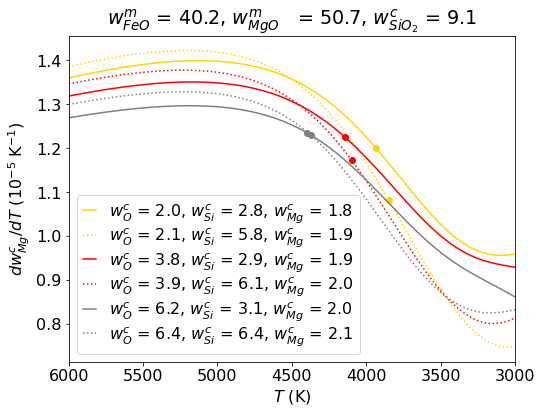

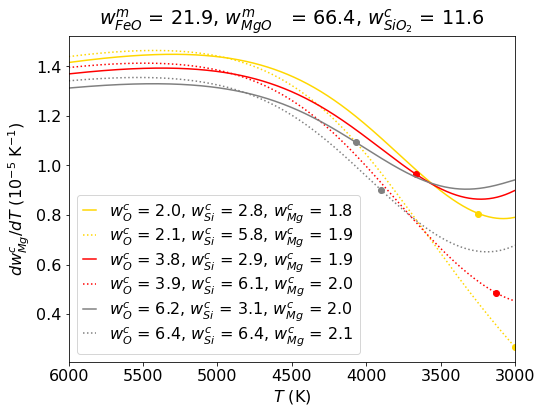

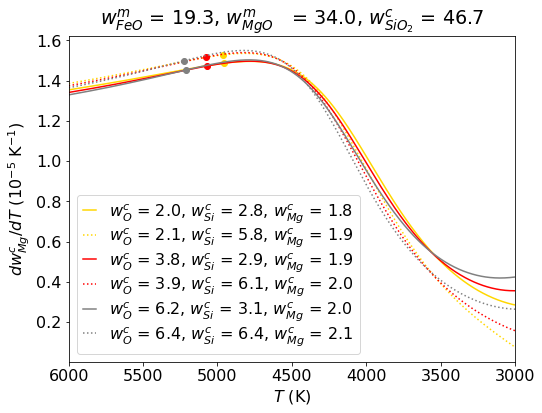

In [8]:
def core_var(NMg, Tcmb, NO_array, NSi_array, NBMO_array):

    fig, ax = plt.subplots(figsize=(8,6))

    dT   = Tcmb[1] - Tcmb[0]

    iMFeO, iMMgO, iMSiO2  = NBMO_array[0], NBMO_array[1], NBMO_array[2]
    Ntot = 780 
    
    Tcrit    = np.zeros([len(NO_array)*len(NSi_array), 3])
    dcdTcrit = np.zeros([len(NO_array)*len(NSi_array), 3])

    ls = ["-", ":"] 
    lc = ["gold", "red", "grey"] 

    ii = 0 
    for NOi, NO in enumerate(NO_array):
        for NSii, NSi in enumerate(NSi_array):

            iMFe, iMO, iMSi, iMMg = Ntot-NO-NSi-NMg, NO, NSi, NMg 
            iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
            B18_E_cvar = mb.run_massbalance(iM, [Kd_Mg_B18_E, Kd_O, Kd_Si], Tcmb, 1, verbose)

            if verbose == 1:
                mb.print_init_conc(B18_E_cvar[0],B18_E_cvar[2])

            dcMgdT_cvar = np.gradient(B18_E_cvar[3][3], dT)*1e5
            dcSidT_cvar = np.gradient(B18_E_cvar[3][2], dT)*1e5
            dcOdT_cvar  = np.gradient(B18_E_cvar[3][1], dT)*1e5

            ax.plot(Tcmb, dcMgdT_cvar, label="$w_O^c$ = "+str(np.round(B18_E_cvar[2][1]*100,1))
                    +", $w_{Si}^c$ = "+str(np.round(B18_E_cvar[2][2]*100,1))
                    +", $w_{Mg}^c$ = "+str(np.round(B18_E_cvar[2][3]*100,1)), 
                    color=lc[NOi], linestyle=ls[NSii])
            ax.plot(Tcmb[B18_E_cvar[4][2]], dcMgdT_cvar[B18_E_cvar[4][2]], color=lc[NOi], marker='o')
  
            Tcrit[ii, 0]    = Tcmb[B18_E_cvar[4][0]] # O
            Tcrit[ii, 1]    = Tcmb[B18_E_cvar[4][1]] # Si
            Tcrit[ii, 2]    = Tcmb[B18_E_cvar[4][2]] # Mg

            dcdTcrit[ii, 0] = B18_E_cvar[6][0][B18_E_cvar[4][0]]
            dcdTcrit[ii, 1] = B18_E_cvar[6][1][B18_E_cvar[4][1]]
            dcdTcrit[ii, 2] = B18_E_cvar[6][2][B18_E_cvar[4][2]]
            
            ii = ii + 1
    
    ax.set_xlim([np.max(Tcmb),np.min(Tcmb)])
    ax.set_xlabel("$T$ (K)")
    ax.set_ylabel("$d w_{Mg}^c/dT$ ($10^{-5}$ K$^{-1}$)")
    ax.set_title("$w_{FeO}^m$ = "+str(np.round(B18_E_cvar[2][4]*100,1))
            +", $w_{MgO}^m$   = "+str(np.round(B18_E_cvar[2][5]*100,1))
            +", $w_{SiO_2}^c$ = "+str(np.round(B18_E_cvar[2][6]*100,1)))
    ax.legend(ncol=1, labelspacing=0.1,handlelength=0.8, columnspacing=0.5)
    
    fig.savefig("var_b18_coreconc_NMg="+str(NMg)+".pdf", format='pdf',bbox_inches="tight")
    
    return fig, ax, Tcrit, dcdTcrit

iMFe, iMO, iMSi, iMMg = 575, 135, 40, 30 # Default composition of 780 atoms in Core and BMO

NBMO_array = [220, 500, 60]
NSi_array  = [40, 80]
NO_array   = [50, 90, 140]

fig, ax, Tcrit1, dcdTcrit1 = core_var(30, Tcmb, NO_array, NSi_array, NBMO_array)

NBMO_array =  [110, 600, 70]
fig, ax, Tcrit2, dcdTcrit2 = core_var(30, Tcmb, NO_array, NSi_array, NBMO_array)

NBMO_array =  [110, 350, 320]
fig, ax, Tcrit3, dcdTcrit3 = core_var(30, Tcmb, NO_array, NSi_array, NBMO_array)

### Effect of oxide composition on the B18 Exchange and Dissociation solns

In [23]:
def ox_var(var, Kd_array, Tcmb): 
    
    Tcrit    = np.zeros([3, 3])
    dcdTcrit = np.zeros([3, 3])

    dT   = Tcmb[1]-Tcmb[0]

    iMFe, iMO, iMSi, iMMg = 790, 190, 50, 40 # Default composition
    iMFeO, iMMgO, iMSiO2  = 220, 500, 60
    iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
    B18_E_m_def    = mb.run_massbalance(iM, Kd_array, Tcmb, var, verbose)
    Tcrit[0, 0]    = Tcmb[B18_E_m_def[4][0]]
    Tcrit[0, 1]    = Tcmb[B18_E_m_def[4][1]]    
    Tcrit[0, 2]    = Tcmb[B18_E_m_def[4][2]]
    dcdTcrit[0, 0] = B18_E_m_def[6][0][B18_E_m_def[4][0]] # O 
    dcdTcrit[0, 1] = B18_E_m_def[6][1][B18_E_m_def[4][1]] # Si 
    dcdTcrit[0, 2] = B18_E_m_def[6][2][B18_E_m_def[4][2]] # Mg
    
    iMFe, iMO, iMSi, iMMg = 790, 190, 50, 40 # Low FeO
    iMFeO, iMMgO, iMSiO2  = 110, 600, 70
    iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
    B18_E_m_highS  = mb.run_massbalance(iM, Kd_array, Tcmb, var, verbose)  
    Tcrit[1, 0]    = Tcmb[B18_E_m_highS[4][0]]
    Tcrit[1, 1]    = Tcmb[B18_E_m_highS[4][1]]    
    Tcrit[1, 2]    = Tcmb[B18_E_m_highS[4][2]]
    dcdTcrit[1, 0] = B18_E_m_highS[6][0][B18_E_m_highS[4][0]] # O 
    dcdTcrit[1, 1] = B18_E_m_highS[6][1][B18_E_m_highS[4][1]] # Si 
    dcdTcrit[1, 2] = B18_E_m_highS[6][2][B18_E_m_highS[4][2]] # Mg
    
    if verbose == 1:
        mb.print_init_conc(B18_E_m_def[0],B18_E_m_def[2])
        mb.print_init_conc(B18_E_m_highS[0],B18_E_m_highS[2])

    iMFe, iMO, iMSi, iMMg = 790, 190, 50, 40 # High SiO2
    iMFeO, iMMgO, iMSiO2  = 110, 350, 320
    iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
    B18_E_m_highF  = mb.run_massbalance(iM, Kd_array, Tcmb, var, verbose)   
    Tcrit[2, 0]    = Tcmb[B18_E_m_highF[4][0]]
    Tcrit[2, 1]    = Tcmb[B18_E_m_highF[4][1]]    
    Tcrit[2, 2]    = Tcmb[B18_E_m_highF[4][2]]
    dcdTcrit[2, 0] = B18_E_m_highF[6][0][B18_E_m_highF[4][0]] # O 
    dcdTcrit[2, 1] = B18_E_m_highF[6][1][B18_E_m_highF[4][1]] # Si 
    dcdTcrit[2, 2] = B18_E_m_highF[6][2][B18_E_m_highF[4][2]] # Mg
            
    dcMgdT_m_def   = np.gradient(B18_E_m_def[3][3], dT)*1e5
    dcMgdT_m_highS = np.gradient(B18_E_m_highS[3][3], dT)*1e5
    dcMgdT_m_highF = np.gradient(B18_E_m_highF[3][3], dT)*1e5

    fig, (ax2, ax1) = plt.subplots(1,2,figsize=(16,6))

    ax1.set_xlim([np.max(Tcmb),np.min(Tcmb)])
    ax1.set_xlabel("$T$ (K)")
    ax1.set_ylabel("$d w_{MgO}^c/dT$ ($10^{-5}$ K$^{-1}$)")
    ax1.plot(Tcmb, dcMgdT_m_def  , label="$c_{FeO}^m$ = "+str(np.round(B18_E_m_def[0][4]*100,1))
            +", $c_{MgO}^m$ = "+str(np.round(B18_E_m_def[0][5]*100,1)), color="red")

    ax1.plot(Tcmb, dcMgdT_m_highS, label="$c_{FeO}^m$ = "+str(np.round(B18_E_m_highS[0][4]*100,1))
            +", $c_{MgO}^m$ = "+str(np.round(B18_E_m_highS[0][5]*100,1)), color="purple")

    ax1.plot(Tcmb, dcMgdT_m_highF, label="$c_{FeO}^m$ = "+str(np.round(B18_E_m_highF[0][4]*100,1))
            +", $c_{MgO}^m$ = "+str(np.round(B18_E_m_highF[0][5]*100,1)), color="blue")
    
    ax1.plot(Tcmb[B18_E_m_def[4][2]]   , dcMgdT_m_def[B18_E_m_def[4][2]]      , marker='o', color="red")
    ax1.plot(Tcmb[B18_E_m_highS[4][2]] , dcMgdT_m_highS[B18_E_m_highS[4][2]]  , marker='o', color="purple")
    ax1.plot(Tcmb[B18_E_m_highF[4][2]] , dcMgdT_m_highF[B18_E_m_highF[4][2]]  , marker='o', color="blue")
    ax1.legend(ncol=1, labelspacing=0.1,handlelength=0.8, columnspacing=0.5)
    
    fig.suptitle("Initial concentrations: $w_{O}^c$  = "+str(np.round(B18_E_m_def[2][1]*100,1)) + 
                 ", $w_{Si}^c$ = "+str(np.round(B18_E_m_def[2][2]*100,1)) +
                 ", $w_{Mg}^c$ = "+str(np.round(B18_E_m_def[2][3]*100,1)))
                 
    ax2.set_xlim([np.max(Tcmb),np.min(Tcmb)])
    ax2.set_xlabel("$T$ (K)")
    ax2.set_ylabel("Weight percent $w_{i}$ (wt\%)")
    ax2.plot(Tcmb, B18_E_m_def[3][3]*100  , color='red'   , label="Mg")
    ax2.plot(Tcmb, B18_E_m_highS[3][3]*100, color='purple')
    ax2.plot(Tcmb, B18_E_m_highF[3][3]*100, color='blue')   
    ax2.plot(Tcmb, B18_E_m_def[3][2]*100  , color='red'   , ls='--', label="Si")
    ax2.plot(Tcmb, B18_E_m_highS[3][2]*100, color='purple', ls='--')
    ax2.plot(Tcmb, B18_E_m_highF[3][2]*100, color='blue'  , ls='--')  
    ax2.plot(Tcmb[B18_E_m_def[4][2]]  , B18_E_m_def[3][3][B18_E_m_def[4][2]]*100    , marker='o', color="red")
    ax2.plot(Tcmb[B18_E_m_highS[4][2]], B18_E_m_highS[3][3][B18_E_m_highS[4][2]]*100, marker='o', color="purple")
    ax2.plot(Tcmb[B18_E_m_highF[4][2]], B18_E_m_highF[3][3][B18_E_m_highF[4][2]]*100, marker='o', color="blue")
    ax2.plot(Tcmb[B18_E_m_def[4][1]]  , B18_E_m_def[3][2][B18_E_m_def[4][1]]*100    , marker='*', color="red")
    ax2.plot(Tcmb[B18_E_m_highS[4][1]], B18_E_m_highS[3][2][B18_E_m_highS[4][1]]*100, marker='*', color="purple")
    ax2.plot(Tcmb[B18_E_m_highF[4][1]], B18_E_m_highF[3][2][B18_E_m_highF[4][1]]*100, marker='*', color="blue")
    ax2.legend()
    
    fig.savefig("var_mantleconc_reaction="+str(var)+".pdf", format='pdf',bbox_inches="tight")
    return Tcrit, dcdTcrit

MgO Exchange
MgO Exchange
MgO Exchange
[4182. 3888. 4953.]
[1.25422726 1.11766671 1.45863459]


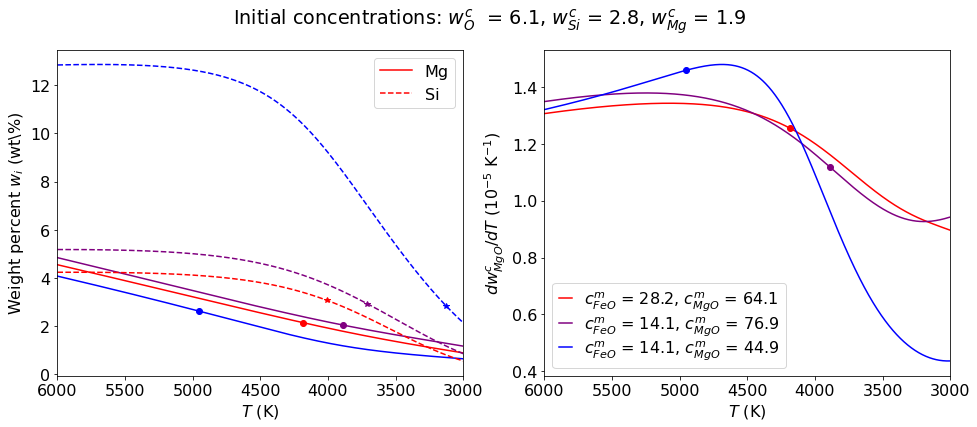

In [25]:
TcritE, dcdtcritE = ox_var(1, [Kd_Mg_B18_E , Kd_O, Kd_Si], Tcmb)
print(TcritE[:,2])

MgO Dissociation
MgO Dissociation
MgO Dissociation
[6000. 6000. 6000.]
[0.60559705 0.64166047 0.57106871]


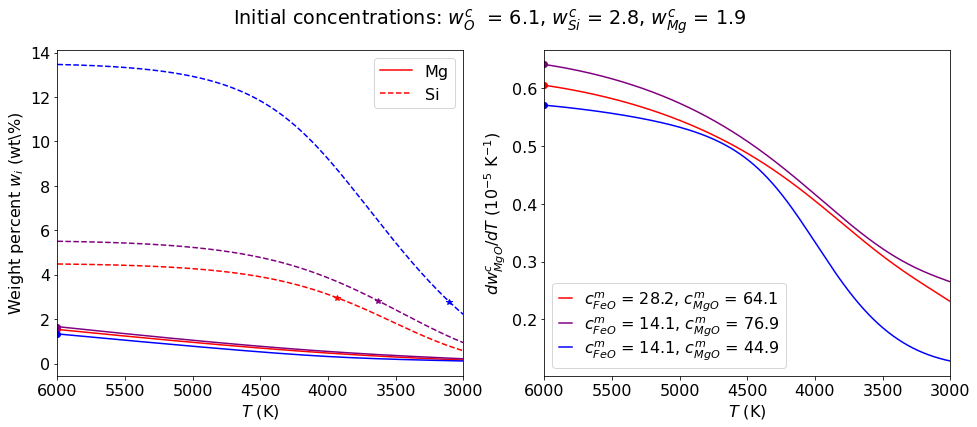

In [24]:
TcritD, dcdtcritD = ox_var(3, [Kd_Mg_B18_Ds, Kd_O, Kd_Si], Tcmb)

MgO and SiO2 Dissociation
MgO and SiO2 Dissociation
MgO and SiO2 Dissociation
[6000. 5691. 6000.]
[0.56889485 0.65195405 0.30598874]


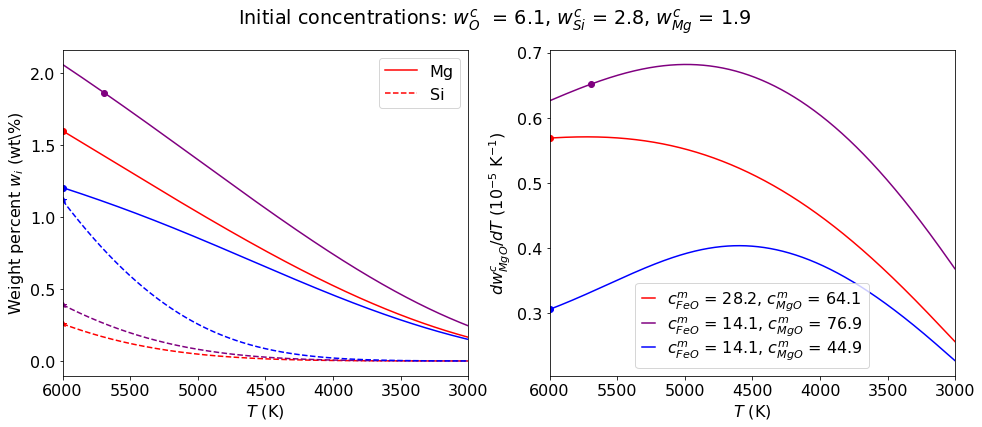

In [26]:
TcritDD, dcdtcritDD = ox_var(2, [Kd_Mg_B18_Ds, Kd_O, Kd_Si_Ds], Tcmb)
print(TcritDD[:,2])
print(dcdtcritDD[:,2])

### Du et al (2019) Fig 3 using their compositions

MgO Exchange
Initial core mole fractions of Fe  =   0.77 O   =   0.18 Si   =   0.05 Mg  =   0.00 All =   1.00
Initial mant mole fractions of FeO =   0.28 MgO =   0.64 SiO2 =   0.08 all =   1.00
Initial core mass fractions of O   =   6.24 Mg  =   0.00 Si  =   2.88
Initial mant mass fractions of FeO =  40.16 MgO =  50.71 SiO2 =   9.13


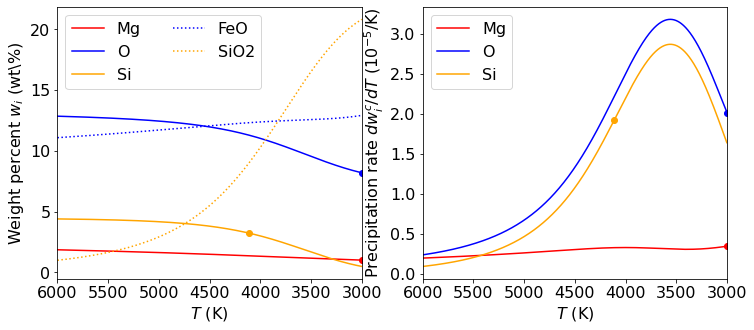

In [27]:
iMFe, iMO, iMSi, iMMg = 79, 19, 5, 0 # Zero Mg as in D19 Fig 3
iMFeO, iMMgO, iMSiO2  = 22, 50, 6
iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
D19_Fig3 = mb.run_massbalance(iM, [Kd_Mg_D19_E, Kd_O, Kd_Si], Tcmb, 1, verbose)
mb.plot_paper(Tcmb, D19_Fig3[5], D19_Fig3[1], D19_Fig3[3], D19_Fig3[4])
mb.print_init_conc(D19_Fig3[0],D19_Fig3[2])

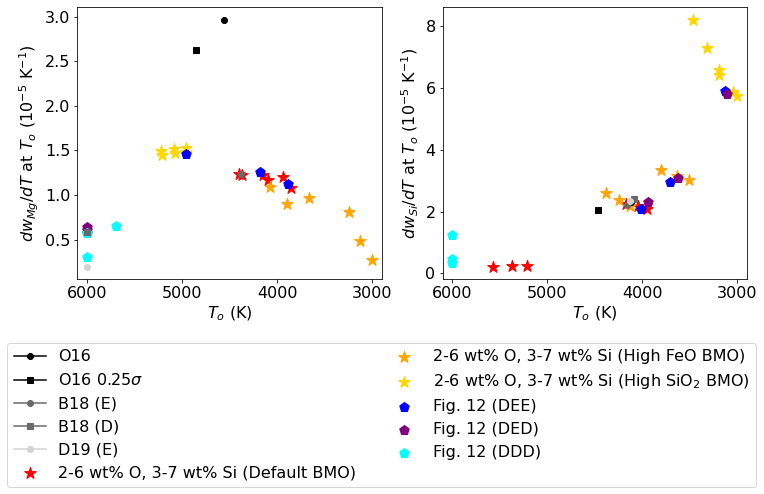

In [40]:
fig, ((ax5, ax3)) = plt.subplots(1, 2, figsize=(12,5))

ax5.set_xlim(6100,2900)
ax5.set_xlabel("$T_{o}$ (K)")
ax5.set_ylabel("$d w_{Mg}/dT$ at $T_{o}$ ($10^{-5}$ K$^{-1}$)")
ax5.plot(Tcmb[O16_E[4][2]]      , O16_E[6][2][O16_E[4][2]]            , color='black'    , marker='o', label="O16")
ax5.plot(Tcmb[O16_E_25s[4][2]]  , O16_E_25s[6][2][O16_E_25s[4][2]]    , color='black'    , marker='s', label="O16 0.25$\sigma$")
ax5.plot(Tcmb[B18_E[4][2]]      , B18_E[6][2][B18_E[4][2]]            , color='dimgrey'  , marker='o', label="B18 (E)")
ax5.plot(Tcmb[B18_D[4][2]]      , B18_D[6][2][B18_D[4][2]]            , color='dimgrey'  , marker='s', label="B18 (D)")
ax5.plot(Tcmb[D19_E[4][2]]      , D19_E[6][2][D19_E[4][2]]            , color='lightgrey', marker='o', label="D19")
ax5.scatter(Tcrit1[:,2] , dcdTcrit1[:,2] , marker="*", color="red"   , s=150, label="2-6 wt\% O, 3-7 wt\% Si (Default BMO)")
ax5.scatter(Tcrit2[:,2] , dcdTcrit2[:,2] , marker="*", color="orange", s=150, label="2-6 wt\% O, 3-7 wt\% Si (High FeO BMO)")
ax5.scatter(Tcrit3[:,2] , dcdTcrit3[:,2] , marker="*", color="gold"  , s=150, label="2-6 wt\% O, 3-7 wt\% Si (High SiO$_2$ BMO)")
ax5.scatter(TcritE[:,2] , dcdtcritE[:,2] , marker="p", color="blue"  , s=100)
ax5.scatter(TcritD[:,2] , dcdtcritD[:,2] , marker="p", color="purple", s=100)
ax5.scatter(TcritDD[:,2], dcdtcritDD[:,2], marker="p", color="cyan"  , s=100)

ax3.set_xlim(6100,2900)
ax3.set_xlabel("$T_{o}$ (K)")
ax3.set_ylabel("$d w_{Si}/dT$ at $T_{o}$ ($10^{-5}$ K$^{-1}$)")
ax3.plot(Tcmb[O16_E[4][1]]      , O16_E[6][1][O16_E[4][1]]        , color='black'    , marker='o', label="O16")
ax3.plot(Tcmb[O16_E_25s[4][1]]  , O16_E_25s[6][1][O16_E_25s[4][1]], color='black'    , marker='s', label="O16 0.25$\sigma$")
ax3.plot(Tcmb[B18_E[4][1]]      , B18_E[6][1][B18_E[4][1]]        , color='dimgrey'  , marker='o', label="B18 (E)")
ax3.plot(Tcmb[B18_D[4][1]]      , B18_D[6][1][B18_E_Fig3D[4][1]]  , color='dimgrey'  , marker='s', label="B18 (D)")
ax3.plot(Tcmb[D19_E[4][1]]      , D19_E[6][1][D19_E[4][1]]        , color='lightgrey', marker='o', label="D19 (E)")
ax3.scatter(Tcrit1[:,1] , dcdTcrit1[:,1] , marker="*" , color="red"   , s=150, label="2-6 wt% O, 3-7 wt% Si (Default BMO)")
ax3.scatter(Tcrit2[:,1] , dcdTcrit2[:,1] , marker="*" , color="orange", s=150, label="2-6 wt% O, 3-7 wt% Si (High FeO BMO)")
ax3.scatter(Tcrit3[:,1] , dcdTcrit3[:,1] , marker="*" , color="gold"  , s=150, label="2-6 wt% O, 3-7 wt% Si (High SiO$_2$ BMO)")
ax3.scatter(TcritE[:,1] , dcdtcritE[:,1] , marker="p" , color="blue"  , s=100, label="Fig. 12 (DEE)")
ax3.scatter(TcritD[:,1] , dcdtcritD[:,1] , marker="p" , color="purple", s=100, label="Fig. 12 (DED)")
ax3.scatter(TcritDD[:,1], dcdtcritDD[:,1], marker="p" , color="cyan"  , s=100, label="Fig. 12 (DDD)")
ax3.legend(loc="center", bbox_to_anchor=(-0.2, -0.5), ncol=2)
fig.savefig("var_synthesis.pdf", format="pdf")

In [15]:
Initial mant mole fractions of FeO =   0.28 MgO =   0.64 SiO2 =   0.08 all =   1.00

SyntaxError: invalid syntax (<ipython-input-15-e5d7880fd28d>, line 1)